In [31]:
import pandas as pd
from utility_functions import cross_validate_and_save_model, vectorize, evaluate,get_confused_samples, get_tag_and_prob
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import matplotlib.pyplot as plt
import random
plt.style.use('dark_background')

# Modify Data
remove all samples with no topic from training data (leave them in test data)

In [2]:
df = pd.read_csv(f'../data/6 - Classification data/full_classification_df.csv')
df.dropna(subset=['NonStopwordsQuoteText'],inplace=True)
print("total number of samples:",df.shape[0])
print(df['Tag'].value_counts())

total number of samples: 2367
בלי           1035
חינוך          214
קורונה         211
רווחה          191
כלכלי          186
נשים           168
בריאות         161
בטחון פנים     102
בטחון           99
Name: Tag, dtype: int64


In [3]:
df = df.sort_values(by=['Tag']).reset_index(drop=True)
first = df['Tag'].gt("בלי").idxmax()
no_topic_lst = df.index[df['Tag'] == "בלי"].tolist()

# drop most samples that are tagged as "no topic" (leave only 200)
first, last = no_topic_lst[0], no_topic_lst[-1]
keep_range = list(range(0, first)) + list(range(last + 1, len(df)))

df = df.iloc[keep_range].reset_index(drop=True)
print(df['Tag'].value_counts())
print("total number of samples:", df.shape[0])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

חינוך         214
קורונה        211
רווחה         191
כלכלי         186
נשים          168
בריאות        161
בטחון פנים    102
בטחון          99
Name: Tag, dtype: int64
total number of samples: 1332


,Type,QuoteWordCount,QuoteLen,StartDate,Speaker,QuoteText,NonStopwordsQuoteText,Tag
0,Committee,23.0,131.0,2020-11-24 09:00:00,"<< יור >> היו""ר מנסור עבאס: << יור >>","בוקר טוב לכולם, אנחנו נפתח את הישיבה המיוחדת ה...",נפתח המיוחדת המיוחדת למיגור הפשיעה והאלימות בכ...,בטחון פנים
1,Committee,46.0,257.0,2018-07-09 09:00:00,"היו""ר עאידה תומא סלימאן:","בוקר טוב לכולם, אני פותחת את הישיבה של הוועדה ...",פותחת לקידום מעמד האישה ולשוויון מגדרי ה- 9 בי...,נשים
2,Committee,143.0,824.0,2020-06-23 10:00:00,"<< יור >> היו""ר רם שפע: << יור >>",מבחינתי זה אחד הדיונים הכי משמעותיים שהיו לנו ...,מבחינתי הדיונים משמעותיים שהיו בתקופה האחרונה ...,חינוך
3,Committee,113.0,577.0,2017-02-20 10:30:00,"היו""ר קארין אלהרר:","תראו, אנחנו עוסקים היום בנושא כאוב ועצוב. הוא ...",תראו עוסקים כאוב ועצוב כאוב ועצוב פעמיים רשלנו...,בריאות
4,Committee,76.0,434.0,2018-11-07 09:00:00,"היו""ר שלי יחימוביץ:",הרבה מאמצים הושקעו בקמפיין האגרסיבי הזה ואני ר...,מאמצים הושקעו בקמפיין האגרסיבי טענה לחברות התר...,בריאות


In [4]:
X = df['NonStopwordsQuoteText']
y = df['Tag']
names = ["X_train", "X_test", "y_train", "y_test"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for name, data in enumerate([X_train, X_test, y_train, y_test]):
    data.reset_index(drop=True, inplace=True)
    data.to_csv(f'../data/7 - Classification Data (phase 2)/{names[name]}.csv', index=0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("Tags distribution:\n")
print("train tags\n", y_train.value_counts(), "\n")
print("test tags\n", y_test.value_counts())

Tags distribution:

train tags
 קורונה        171
חינוך         169
רווחה         155
כלכלי         151
בריאות        134
נשים          130
בטחון          79
בטחון פנים     76
Name: Tag, dtype: int64 

test tags
 חינוך         45
קורונה        40
נשים          38
רווחה         36
כלכלי         35
בריאות        27
בטחון פנים    26
בטחון         20
Name: Tag, dtype: int64


## Vectorize data

In [5]:
X_train_counts, X_test_counts = vectorize(X_train, X_test,"simple_counts")
X_train_tfidf, X_test_tfidf = vectorize(X_train, X_test,"tfidf")

simple counts: 1065 quotes, 44200 words in train set
TFIDF: 1065 quotes, 44200 words in train set


# Classificaiton models
## Logistic Regression
#### Logistic Regression with simple counts

In [6]:
logistic_simple_model, logistic_simple_predicted, logistic_simple_proba = cross_validate_and_save_model(LogisticRegression(), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_simple_counts',3, proba=True)

cross validation scores (5fold) for logistic_simple_counts:
accuracy: 0.6291079812206573
precision_macro: 0.6952971930484957
recall_macro: 0.5853749804511961
f1_macro: 0.5988592806622259


In [7]:
logistic_c2_simple_model, logistic_c2_simple_predicted,logistic_c2_simple_proba = cross_validate_and_save_model(LogisticRegression(C=2), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c2_simple_counts',3, proba=True)

cross validation scores (5fold) for logistic_c2_simple_counts:
accuracy: 0.6309859154929578
precision_macro: 0.6918924044502853
recall_macro: 0.5874356294058999
f1_macro: 0.6006454421611258


In [8]:
logistic_c05_simple_model, logistic_c05_simple_predicted, logistic_c05_simple_proba = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c05_simple_counts',3, proba=True)

cross validation scores (5fold) for logistic_c05_simple_counts:
accuracy: 0.6272300469483568
precision_macro: 0.6982364263608019
recall_macro: 0.5823149906724563
f1_macro: 0.595385718705381


#### Logistic Regression with TFIDF

In [9]:
logistic_tfidf_model, logistic_tfidf_predicted,logistic_tfidf_proba= cross_validate_and_save_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_tfidf_counts',3, proba=True)

cross validation scores (5fold) for logistic_tfidf_counts:
accuracy: 0.5737089201877934
precision_macro: 0.7003120209748681
recall_macro: 0.5115798302300685
f1_macro: 0.5131084703042215


In [10]:
logistic_c05_tfidf_model, logistic_c05_tfidf_predicted,logistic_c05_tfidf_proba = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_c05_tfidf_counts',3, proba=True)

cross validation scores (5fold) for logistic_c05_tfidf_counts:
accuracy: 0.5549295774647888
precision_macro: 0.5654225922229925
recall_macro: 0.48801871026165944
f1_macro: 0.48091085424346475


## Random Forest
#### Random forest with simple counts

In [11]:
forest_30_100_simple_model, forest_30_100_simple_predicted,forest_30_100_simple_proba = cross_validate_and_save_model(RandomForestClassifier(n_estimators=30, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_30_100_simple_counts',3, proba=True)

cross validation scores (5fold) for forest_30_100_simple_counts:
accuracy: 0.5990610328638498
precision_macro: 0.6670264003655678
recall_macro: 0.560567257466096
f1_macro: 0.5739417555462902


In [12]:
forest_100_100_simple_model, forest_100_100_simple_predicted,forest_100_100_simple_proba = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_100_simple_counts',3, proba=True)

cross validation scores (5fold) for forest_100_100_simple_counts:
accuracy: 0.6253521126760563
precision_macro: 0.6954960028232946
recall_macro: 0.5878368679904687
f1_macro: 0.6049289117083083


In [13]:
forest_200_100_simple_model, forest_200_100_simple_predicted,forest_200_100_simple_proba= cross_validate_and_save_model(RandomForestClassifier(n_estimators=200, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_200_100_simple_counts',3, proba=True)

cross validation scores (5fold) for forest_200_100_simple_counts:
accuracy: 0.6394366197183098
precision_macro: 0.7215067575720318
recall_macro: 0.6026646526482567
f1_macro: 0.6182848637225187


In [14]:
forest_100_200_simple_model, forest_100_200_simple_predicted, forest_100_200_simple_proba = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_200_simple_counts',3, proba=True)

cross validation scores (5fold) for forest_100_200_simple_counts:
accuracy: 0.6046948356807512
precision_macro: 0.6865546584011835
recall_macro: 0.5614940410256458
f1_macro: 0.5729566785111784


In [15]:
forest_100_1000_simple_model, forest_100_1000_simple_predicted, forest_100_1000_simple_proba= cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_1000_simple_counts',3, proba=True)

cross validation scores (5fold) for forest_100_1000_simple_counts:
accuracy: 0.5793427230046948
precision_macro: 0.6721959042040596
recall_macro: 0.5326369935373312
f1_macro: 0.5458904621850811


In [16]:
forest_150_1000_simple_model, forest_150_1000_simple_predicted, forest_150_1000_simple_proba = cross_validate_and_save_model(RandomForestClassifier(n_estimators=150, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_150_1000_simple_counts',3, proba=True)

cross validation scores (5fold) for forest_150_1000_simple_counts:
accuracy: 0.580281690140845
precision_macro: 0.7053939498387884
recall_macro: 0.5375045189584521
f1_macro: 0.5560124241225537


#### Random forest with TFIDF

In [17]:
forest_100_200_tfidf_model, forest_100_200_tfidf_predicted, forest_100_200_tfidf_proba = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_200_tfidf_counts',3, proba=True)

cross validation scores (5fold) for forest_100_200_tfidf_counts:
accuracy: 0.6056338028169014
precision_macro: 0.7340417781944342
recall_macro: 0.565136901958482
f1_macro: 0.5841382665598948


In [18]:
forest_100_1000_tfidf_model, forest_100_1000_tfidf_predicted, forest_100_1000_tfidf_proba = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_1000_tfidf_counts',3, proba=True)

cross validation scores (5fold) for forest_100_1000_tfidf_counts:
accuracy: 0.5971830985915493
precision_macro: 0.7264121815570258
recall_macro: 0.551877569720043
f1_macro: 0.5723470181946252


# Evaluation

In [19]:
quotes = X_test.reset_index()
quotes['true'] = y_test
mat_tags = list(logistic_simple_model.classes_)
quotes

,index,NonStopwordsQuoteText,true
0,0,ערכי יעד ערכים שואפים כמדינה וכציבור לעמוד בהם...,בריאות
1,1,לכולן פותחת הועדה לקידום מעמד האישה ולשוויון מ...,נשים
2,2,בשיחות שקיימתי האוצר ובשיחות שקיימתי יושב-ראש ...,כלכלי
3,3,הודעה קצרה מתחילים ביומיים האחרונים תחת מתקפה ...,נשים
4,4,פותחת לקידום מעמד האישה ולשוויון מגדרי ישיבה מ...,נשים
...,...,...,...
262,262,איתנו החינוך המזכירות הפדגוגית בתחומו נתחיל שת...,חינוך
263,263,היינו אצל עאידה תומא סלימאן לקידום מעמד האישה ...,נשים
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה
265,265,ושבוע בעיניי מהיותר חשובים שהוועדה עוסק בבעיה ...,קורונה


## Logistic regression

-------Logistic Regression simple counts, C=1) Evaluation-------
Micro:
precision: 0.6479400749063671
recall: 0.6479400749063671
f1: 0.6479400749063671

Macro:
precision: 0.7046784578094228
recall: 0.6113504916136495
f1: 0.6150471638798951

Accuracy: 0.6479400749063671

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 94 (0.0%)

Distribution of misclassified topics:
כלכלי         43
רווחה         25
בריאות        12
חינוך          5
בטחון          3
נשים           2
בטחון פנים     2
קורונה         2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,כלכלי
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
16,16,עיקר המחלוקת נסוב הענף מכסות חדשות באיזה היקפי...,כלכלי,רווחה
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,בריאות
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,כלכלי
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,בריאות
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,בטחון פנים


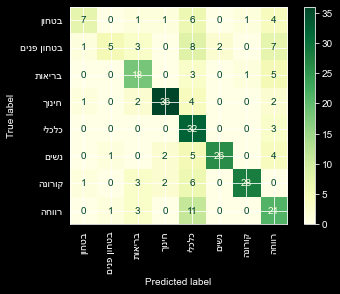

In [48]:
evaluate("-------Logistic Regression simple counts, C=1) Evaluation-------",y_test,logistic_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_simple_predicted)

-------Logistic Regression simple counts, C=2) Evaluation-------
Micro:
precision: 0.651685393258427
recall: 0.651685393258427
f1: 0.651685393258427

Macro:
precision: 0.7058860444721724
recall: 0.6159801212432792
f1: 0.6180659172915974

Accuracy: 0.651685393258427

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 93 (0.0%)

Distribution of misclassified topics:
כלכלי         42
רווחה         24
בריאות        13
חינוך          5
בטחון          3
נשים           2
בטחון פנים     2
קורונה         2
Name: predicted, dtype: int64


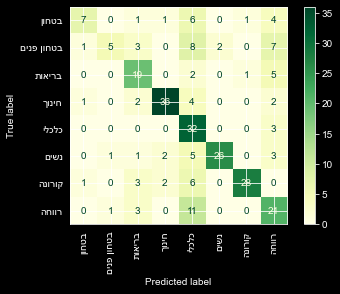

In [59]:
evaluate("-------Logistic Regression simple counts, C=2) Evaluation-------",y_test,logistic_c2_simple_predicted,mat_tags)
predicted = get_confused_samples(quotes,logistic_c2_simple_predicted)

-------Logistic Regression simple counts, C=0.5) Evaluation-------
Micro:
precision: 0.6404494382022472
recall: 0.6404494382022472
f1: 0.6404494382022472

Macro:
precision: 0.7021107456140351
recall: 0.6039430842062421
f1: 0.6094829455123574

Accuracy: 0.6404494382022472

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 96 (0.0%)

Distribution of misclassified topics:
כלכלי         44
רווחה         27
בריאות        11
חינוך          5
בטחון          3
נשים           2
בטחון פנים     2
קורונה         2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,כלכלי
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
16,16,עיקר המחלוקת נסוב הענף מכסות חדשות באיזה היקפי...,כלכלי,רווחה
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,כלכלי
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,כלכלי
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,בריאות
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,בטחון פנים


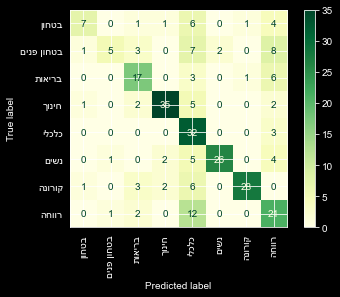

In [50]:
evaluate("-------Logistic Regression simple counts, C=0.5) Evaluation-------",y_test,logistic_c05_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_simple_predicted)

-------Logistic Regression TFIDF counts, C=1) Evaluation-------
Micro:
precision: 0.6479400749063671
recall: 0.6479400749063671
f1: 0.6479400749063671

Macro:
precision: 0.7798761675224601
recall: 0.5942479730308677
f1: 0.581178279382955

Accuracy: 0.6479400749063671

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 94 (0.0%)

Distribution of misclassified topics:
רווחה     49
כלכלי     23
בריאות    11
חינוך      6
קורונה     3
נשים       2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,כלכלי
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
16,16,עיקר המחלוקת נסוב הענף מכסות חדשות באיזה היקפי...,כלכלי,רווחה
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,בריאות
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,רווחה
...,...,...,...,...
253,253,פותחים לביטחון פנים 12 באוקטובר בחשוון התשפב פ...,בטחון פנים,כלכלי
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,בריאות
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,כלכלי


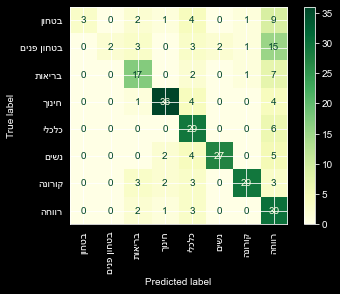

In [51]:
evaluate("-------Logistic Regression TFIDF counts, C=1) Evaluation-------",y_test,logistic_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_tfidf_predicted)

-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------
Micro:
precision: 0.6179775280898876
recall: 0.6179775280898876
f1: 0.6179775280898876

Macro:
precision: 0.7883766939328416
recall: 0.5600052481631429
f1: 0.5536692604925092

Accuracy: 0.6179775280898876

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 102 (0.0%)

Distribution of misclassified topics:
רווחה     62
כלכלי     25
חינוך      6
בריאות     4
קורונה     3
נשים       2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
0,0,ערכי יעד ערכים שואפים כמדינה וכציבור לעמוד בהם...,בריאות,רווחה
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,רווחה
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
16,16,עיקר המחלוקת נסוב הענף מכסות חדשות באיזה היקפי...,כלכלי,רווחה
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,רווחה
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,כלכלי
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,כלכלי
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה,כלכלי


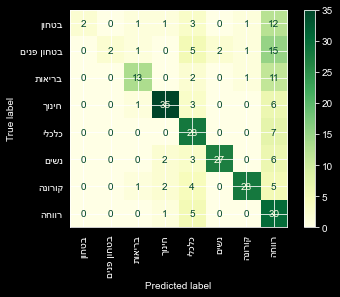

In [52]:
evaluate("-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------",y_test,logistic_c05_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_tfidf_predicted)

## Random forest

-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.6779026217228464
recall: 0.6779026217228464
f1: 0.6779026217228464

Macro:
precision: 0.7597608835200746
recall: 0.6381416281087333
f1: 0.6499044312685287

Accuracy: 0.6779026217228464

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 86 (0.0%)

Distribution of misclassified topics:
כלכלי         50
רווחה         13
בריאות        10
חינוך          6
נשים           4
בטחון פנים     1
קורונה         1
בטחון          1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,כלכלי
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,כלכלי
19,19,קיימנו והופתענו לגלות שהיו חסרים בצורת האכיפה ...,בטחון פנים,כלכלי
20,20,מתחילות בסימן 20 לחוק למניעת הטרדה מינית מהפכה...,בטחון פנים,נשים
...,...,...,...,...
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,חינוך
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה,כלכלי


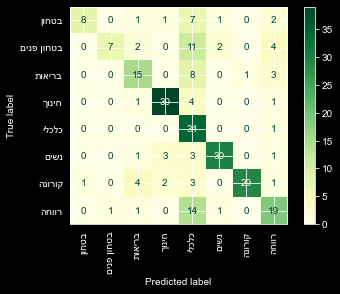

In [53]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_simple_predicted)

In [90]:
evaluate("-----Random forest with simple counts, 200 trees, max depth 100) Evaluation-----",y_test,forest_200_100_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_200_100_simple_predicted)

-----Random forest with simple counts, 200 trees, max depth 100) Evaluation-----
Micro:
precision: 0.6741573033707865
recall: 0.6741573033707865
f1: 0.6741573033707865

Macro:
precision: 0.7265145398973053
recall: 0.6303394704710494
f1: 0.6342419899303131

Accuracy: 0.6741573033707865

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 87 (0.0%)

Distribution of misclassified topics:
כלכלי         36
רווחה         24
בריאות        10
חינוך          7
נשים           4
קורונה         3
בטחון          2
בטחון פנים     1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
11,11,איתנו נציגים ומפעילים המסגרות נציגים העבודה וה...,חינוך,רווחה
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,רווחה
19,19,קיימנו והופתענו לגלות שהיו חסרים בצורת האכיפה ...,בטחון פנים,רווחה
20,20,מתחילות בסימן 20 לחוק למניעת הטרדה מינית מהפכה...,בטחון פנים,נשים
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,בריאות
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה,כלכלי



KeyboardInterrupt



<Figure size 432x288 with 2 Axes>

-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.6329588014981273
recall: 0.6329588014981273
f1: 0.6329588014981273

Macro:
precision: 0.7685113890876496
recall: 0.5913412671636356
f1: 0.6092588568656758

Accuracy: 0.6329588014981273

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 98 (0.0%)

Distribution of misclassified topics:
כלכלי     70
רווחה     11
חינוך      5
נשים       4
בריאות     4
קורונה     2
בטחון      2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,כלכלי
11,11,איתנו נציגים ומפעילים המסגרות נציגים העבודה וה...,חינוך,רווחה
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
16,16,עיקר המחלוקת נסוב הענף מכסות חדשות באיזה היקפי...,כלכלי,רווחה
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,כלכלי
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,כלכלי
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,כלכלי


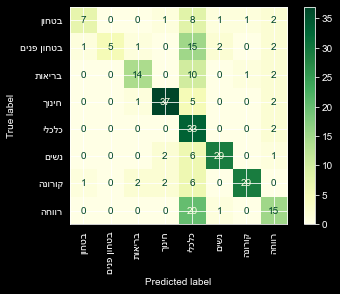

In [54]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_simple_predicted)

-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.6254681647940075
recall: 0.6254681647940075
f1: 0.6254681647940075

Macro:
precision: 0.7783802972412961
recall: 0.5833844092067777
f1: 0.6030355574073522

Accuracy: 0.6254681647940075

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 100 (0.0%)

Distribution of misclassified topics:
כלכלי     75
רווחה      8
בריאות     6
חינוך      5
נשים       3
קורונה     2
בטחון      1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,כלכלי
11,11,איתנו נציגים ומפעילים המסגרות נציגים העבודה וה...,חינוך,רווחה
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,כלכלי
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,כלכלי
...,...,...,...,...
253,253,פותחים לביטחון פנים 12 באוקטובר בחשוון התשפב פ...,בטחון פנים,כלכלי
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,כלכלי
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה,כלכלי


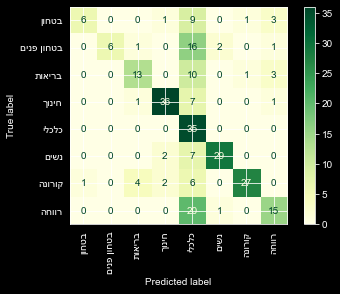

In [55]:
evaluate("-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----",y_test,forest_150_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_150_1000_simple_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.6591760299625468
recall: 0.6591760299625468
f1: 0.6591760299625468

Macro:
precision: 0.7132115800865801
recall: 0.6159359402780455
f1: 0.6198826367198761

Accuracy: 0.6591760299625468

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 91 (0.0%)

Distribution of misclassified topics:
כלכלי         42
רווחה         21
בריאות        12
חינוך          5
נשים           5
קורונה         3
בטחון          2
בטחון פנים     1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,כלכלי
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,רווחה
19,19,קיימנו והופתענו לגלות שהיו חסרים בצורת האכיפה ...,בטחון פנים,כלכלי
20,20,מתחילות בסימן 20 לחוק למניעת הטרדה מינית מהפכה...,בטחון פנים,נשים
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,כלכלי
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,בריאות


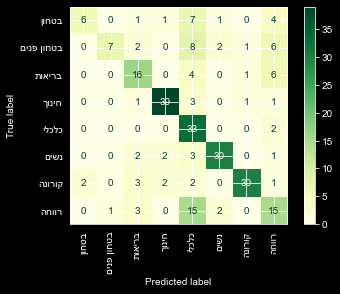

In [56]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_tfidf_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.6254681647940075
recall: 0.6254681647940075
f1: 0.6254681647940075

Macro:
precision: 0.7204982907653067
recall: 0.5805443094916779
f1: 0.5851042551348189

Accuracy: 0.6254681647940075

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 100 (0.0%)

Distribution of misclassified topics:
כלכלי         66
בריאות        10
רווחה          9
חינוך          6
נשים           5
בטחון          2
בטחון פנים     1
קורונה         1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
11,11,איתנו נציגים ומפעילים המסגרות נציגים העבודה וה...,חינוך,רווחה
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,כלכלי
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,כלכלי
19,19,קיימנו והופתענו לגלות שהיו חסרים בצורת האכיפה ...,בטחון פנים,כלכלי
...,...,...,...,...
255,255,22 בדצמבר 1303 פותחת העבודה הרווחה והבריאות המ...,רווחה,בריאות
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,כלכלי
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,חינוך
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה,כלכלי


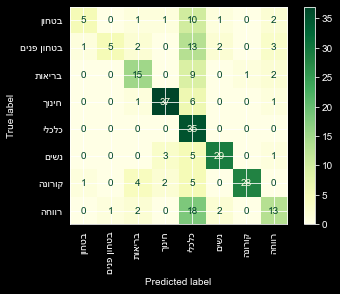

In [57]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_tfidf_predicted)

## Probabilistic threshold

probability of incorrect tags


<AxesSubplot:>

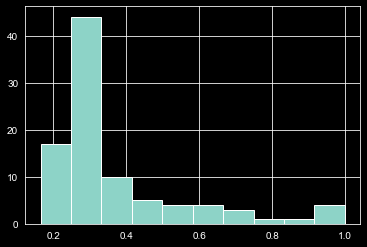

In [68]:
prob = get_tag_and_prob(logistic_c2_simple_proba, y_test)
print("probability of incorrect tags")
prob[prob['Tag']!=prob['true']]['max_prob'].hist()

probability of correct tags


<AxesSubplot:>

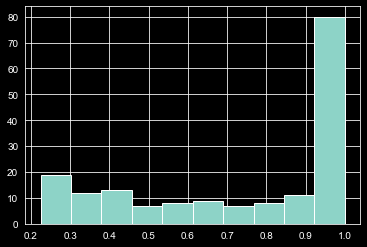

In [67]:
print("probability of correct tags")
prob[prob['Tag']==prob['true']]['max_prob'].hist()

number of samples with probability <= 0.3 that were tagged as no topic: 202 of 267 - 24.344569288389508%
percent of mssclassified samples - 17.60299625468165%
number of misclassified samples - 47

-------Logistic Regression simple counts with prob >= 0.3, C=2) Evaluation-------
Micro:
precision: 0.7673267326732673
recall: 0.7673267326732673
f1: 0.7673267326732673

Macro:
precision: 0.7899624572393451
recall: 0.7094868399144715
f1: 0.7196853838798254

Accuracy: 0.7673267326732673

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 112 (0.0%)

Distribution of misclassified topics:
כלכלי         18
רווחה         14
חינוך          5
בריאות         4
נשים           2
קורונה         2
בטחון פנים     1
בטחון          1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
7,7,מאין כמותו מברך היוזמה חברות אמילי מואטי ענבר ...,נשים,כלכלי
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
16,16,עיקר המחלוקת נסוב הענף מכסות חדשות באיזה היקפי...,כלכלי,רווחה
17,17,הוועדות ניסו לבדוק היקף הפרשה ונסיבותיה החקירה...,רווחה,NaN
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,כלכלי
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,NaN
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,NaN
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,NaN
261,261,הבוקר נפתח בהצבעה מיזוג שתי הצעות פרטיות נוספו...,נשים,NaN


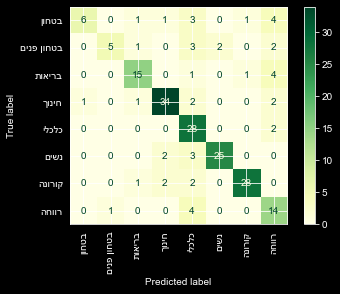

In [81]:
joined = pd.concat((logistic_c2_simple_predicted, prob),axis=1).drop(columns=['Tag'])
joined = joined[joined['max_prob'] >= 0.3]
joined_predicted, joined_true = joined['predicted'], joined['true']
print(f"number of samples with probability <= 0.3 that were tagged as no topic: {len(joined)} of {len(logistic_simple_predicted)} - {100 -(len(joined)*100/len(logistic_simple_predicted))}%")
print(f"number of misclassified samples - {len(joined)}\n")
print(f"percent of mssclassified samples - {len(joined[joined['predicted']!= joined['true']])*100/len(logistic_simple_predicted)}%")
print(f"number of misclassified samples - {len(joined[joined['predicted']!= joined['true']])}\n")
evaluate("-------Logistic Regression simple counts with prob >= 0.3, C=2) Evaluation-------",joined_true,joined_predicted,mat_tags)
get_confused_samples(quotes,joined_predicted)


number of samples with probability <= 0.3 that were tagged as no topic: 248 of 267 - 7.116104868913851%
number of no topic samples - 248

percent of misclassified samples - 25.84269662921348%
number of misclassified samples - 69

-------Logistic Regression simple counts with prob >= 0.3, C=2) Evaluation-------
Micro:
precision: 0.7217741935483871
recall: 0.7217741935483871
f1: 0.7217741935483872

Macro:
precision: 0.7525126777620048
recall: 0.6732467491191747
f1: 0.6738203071083506

Accuracy: 0.7217741935483871

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 0 of 88 (0.0%)

Distribution of misclassified topics:
כלכלי         23
רווחה         22
בריאות         8
חינוך          7
נשים           3
קורונה         3
בטחון          2
בטחון פנים     1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
11,11,איתנו נציגים ומפעילים המסגרות נציגים העבודה וה...,חינוך,רווחה
12,12,החינוך התרבות והספורט השלישית ומספר 565 מתחילת...,נשים,חינוך
18,18,להודות לחברת myheritage שעושה נהדרת ובסבלנות ו...,בריאות,רווחה
19,19,קיימנו והופתענו לגלות שהיו חסרים בצורת האכיפה ...,בטחון פנים,רווחה
20,20,מתחילות בסימן 20 לחוק למניעת הטרדה מינית מהפכה...,בטחון פנים,נשים
...,...,...,...,...
254,254,התחלתי אמרתי שבכנסת הקודמת איזו אמירה ייחוס רי...,בטחון פנים,בריאות
257,257,שכחתי בלגן בכותל בשבט רצינו לדון בשאלה לחדש הז...,כלכלי,רווחה
260,260,נתונים היפגעות מתחילת שנת שרק להסתכל להזדעזע 6...,רווחה,NaN
264,264,שעסקנו הכלכלה העסקים בישראל ובקורונה ובאומיקרו...,קורונה,כלכלי


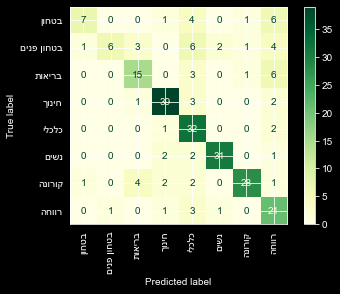

In [88]:
prob = get_tag_and_prob(forest_200_100_simple_proba, y_test)
joined = pd.concat((forest_200_100_simple_predicted, prob),axis=1).drop(columns=['Tag'])
joined = joined[joined['max_prob'] >= 0.2]
joined_predicted, joined_true = joined['predicted'], joined['true']
print(f"number of samples with probability <= 0.3 that were tagged as no topic: {len(joined)} of {len(logistic_simple_predicted)} - {100 -(len(joined)*100/len(logistic_simple_predicted))}%")
print(f"number of no topic samples - {len(joined)}\n")
print(f"percent of misclassified samples - {len(joined[joined['predicted']!= joined['true']])*100/len(logistic_simple_predicted)}%")
print(f"number of misclassified samples - {len(joined[joined['predicted']!= joined['true']])}\n")
evaluate("-------Logistic Regression simple counts with prob >= 0.3, C=2) Evaluation-------",joined_true,joined_predicted,mat_tags)
get_confused_samples(quotes,joined_predicted)

<AxesSubplot:>

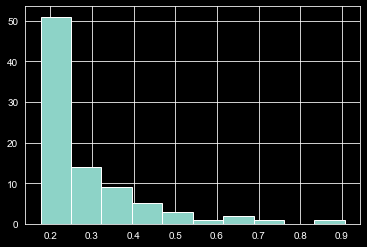

In [87]:
prob[prob['Tag']!=prob['true']]['max_prob'].hist()